# MAL Analysis - Popularity

## Cleaning

In [1]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('mal_pop_1000.csv').drop(columns="Unnamed: 0")
df.head(2)

,Title,Rank,Popularity,Score,Score_Count,Members,Favorites,Type,Episodes,Status,Season,Year,Producers,Licensors,Studios,Genres,Themes,Demographic
0,Shingeki no Kyojin,111,1,8.53,2606155.0,3666477,160638,TV,25,Finished Airing,Spring,2013,"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],['Wit Studio'],"['Action', 'Award Winning', 'Drama', 'Suspense']","['Gore', 'Military', 'Survival']",Shounen
1,Death Note,80,2,8.62,2569010.0,3640099,164958,TV,37,Finished Airing,Fall,2006,"['VAP', 'Konami', 'Ashi Productions', 'Nippon ...",['VIZ Media'],['Madhouse'],"['Supernatural', 'Suspense']",Psychological,Shounen


In [4]:
df_clean = df.copy()
df_clean.loc[df_clean['Episodes'] == 'Unknown', 'Episodes'] = 0
df_clean['Episodes'] = df_clean['Episodes'].astype(int)

df_clean['Producers'] = df_clean['Producers'].apply(lambda x: x[1:-1].replace("'","").replace('add some', '').split(', '))
df_clean['Studios'] = df_clean['Studios'].apply(lambda x: x[1:-1].replace("'","").split(', '))
df_clean['Licensors'] = df_clean[df_clean['Licensors'] != '']['Licensors'].apply(lambda x: x[1:-1].replace("'","").replace('add some', '').split(', '))
df_clean['Themes'] = df_clean[~df_clean['Themes'].isna()]['Themes'].astype(str)
df_clean['Themes'] = df_clean[~df_clean['Themes'].isna()]['Themes'].apply(lambda x: list(map(str, x.replace("'", "").strip('[]').split(', '))) if ',' in x else [x.replace('nan', '')])
df_clean['Genres'] = df_clean[~df_clean['Genres'].isna()]['Genres'].astype(str)
df_clean['Genres'] = df_clean[~df_clean['Genres'].isna()]['Genres'].apply(lambda x: x[1:-1].replace("'","").replace('add some', '').split(', '))

df_clean.loc[df_clean['Licensors'].apply(lambda x: len(x) == 1 and '' in x), 'Licensors'] = df_clean[df_clean['Licensors'].apply(lambda x: len(x) == 1 and '' in x)]['Licensors'].apply(lambda x: np.NaN)
df_clean.loc[df_clean['Producers'].apply(lambda x: len(x) == 1 and '' in x), 'Producers'] = df_clean[df_clean['Producers'].apply(lambda x: len(x) == 1 and '' in x)]['Producers'].apply(lambda x: np.NaN)

df_clean.head(3)

,Title,Rank,Popularity,Score,Score_Count,Members,Favorites,Type,Episodes,Status,Season,Year,Producers,Licensors,Studios,Genres,Themes,Demographic
0,Shingeki no Kyojin,111,1,8.53,2606155.0,3666477,160638,TV,25,Finished Airing,Spring,2013,"[Production I.G, Dentsu, Mainichi Broadcasting...",[Funimation],[Wit Studio],"[Action, Award Winning, Drama, Suspense]","[Gore, Military, Survival]",Shounen
1,Death Note,80,2,8.62,2569010.0,3640099,164958,TV,37,Finished Airing,Fall,2006,"[VAP, Konami, Ashi Productions, Nippon Televis...",[VIZ Media],[Madhouse],"[Supernatural, Suspense]",[Psychological],Shounen
2,Fullmetal Alchemist: Brotherhood,2,3,9.11,1973141.0,3104299,214087,TV,64,Finished Airing,Spring,2009,"[Aniplex, Square Enix, Mainichi Broadcasting S...","[Funimation, Aniplex of America]",[Bones],"[Action, Adventure, Drama, Fantasy]",[Military],Shounen


In [5]:
# Exploade to include different values for later studies
df_exploded = ((((df_clean.explode('Producers')).explode('Licensors')).explode('Studios')).explode('Genres')).explode('Themes')

### Studio Specific Information

In [6]:
# Due to abundance of small companies, catgorize these studios as others
df_exploded_studios = df_clean.explode('Studios').reset_index(drop = True)
studio_stats = df_exploded_studios.groupby(['Studios']).size().sort_values(ascending=False).reset_index(drop = False)
small_studio_arrays = studio_stats[studio_stats[0] <= 3]['Studios'].unique()
df_exploded_studios['Studios'] = df_exploded_studios['Studios'].replace(small_studio_arrays, 'Others')
df_exploded_studios['Studios'] = df_exploded_studios['Studios'].replace('add some', 'Others')
# df_exploded_studios.head(3)

df_exploded['Studios'] = df_exploded['Studios'].replace(small_studio_arrays, 'Others')
df_exploded['Studios'] = df_exploded['Studios'].replace('add some', 'Others')
# df_exploded.to_csv('mal-exploded.csv', index=False)


In [26]:
### KEY:
## df_exploded_studs = info of studios
## df_exploded_lic = info of licensors 
## df_exploded_stugen = info of studios + genres
## df_exploded_themes = info of themes
## df_exploded_prod = info of producers
## df_exploded_gens = info of genres
key_cols = np.array(range(12))

df_exploded_studs = df_exploded_studios.copy()
df_exploded_studs = df_exploded_studs.iloc[:,np.append(key_cols, [14,17])]
df_exploded_studs = df_exploded_studs.drop_duplicates()

df_exploded_lic = df_exploded.iloc[:,np.append(key_cols, [13,17])]
df_exploded_lic = df_exploded_lic.drop_duplicates()
df_exploded_lic['Duplicate_Count'] = df_exploded_lic.duplicated(subset=['Title'], keep=False).astype(int)
df_exploded_lic['Duplicates'] = df_exploded_lic.groupby('Title')['Duplicate_Count'].transform('sum')
df_exploded_lic = df_exploded_lic.drop(columns='Duplicate_Count').replace(0, 1)
df_exploded_lic['adj_members'] = df_exploded_lic['Members']/df_exploded_lic['Duplicates']

df_exploded_stugen = df_exploded.iloc[:,np.append(key_cols, [14,15,17])]
df_exploded_stugen = df_exploded_stugen.drop_duplicates()

df_exploded_themes = df_exploded.iloc[:,np.append(key_cols, [16,17])]
df_exploded_themes = df_exploded_themes.drop_duplicates()

df_exploded_prod = df_exploded.iloc[:,np.append(key_cols, [12,17])]
df_exploded_prod = df_exploded_prod.drop_duplicates()

df_exploded_gens = df_exploded.iloc[:,np.append(key_cols, [15,17])]
df_exploded_gens = df_exploded_gens.drop_duplicates()

# df_exploded_studs.to_csv('pop_exploded_studs.csv', index=False)
# df_exploded_lic.to_csv('pop_exploded_lic.csv', index=False)
# df_exploded_stugen.to_csv('pop_exploded_stugen.csv', index=False)
# df_exploded_themes.to_csv('pop_exploded_themes.csv', index=False)
# df_exploded_prod.to_csv('pop_exploded_prod.csv', index=False)
# df_exploded_gens.to_csv('pop_exploded_gens.csv', index=False)
full_mal_data = df_clean.copy()

## Exploratory Data Analysis

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as sstats
import statsmodels.stats.api as sms
import scipy as sp
import scipy.stats as ss

Since we are only interested in completed animated tv series, we will only focus on tv shows that have completed airing. 

### Scores

Text(7.45, -3, '7.601')

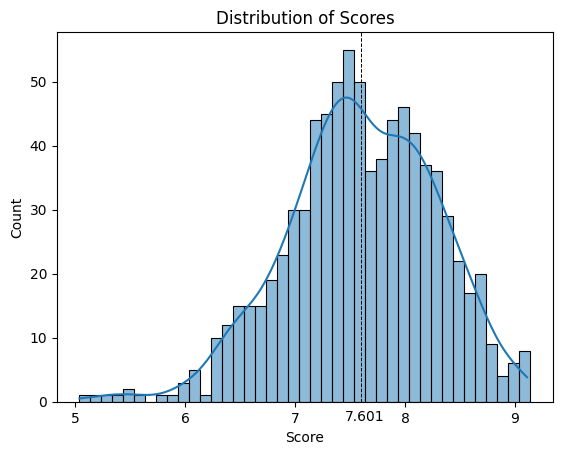

In [157]:
mal_data = full_mal_data[(full_mal_data['Status'] == "Finished Airing") & (full_mal_data['Type'] == "TV")]

score_avg = np.average(mal_data['Score'])
# plt.hist(mal_data['Score'],bins = 30)
plt.axvline(x = score_avg, color='black', label = np.round(score_avg, 1), ls = '--', lw = 0.7)
plt.title('Distribution of Scores')
sns.histplot(data = mal_data, x='Score', binwidth = 0.1, kde = True)
plt.text(7.45,-3,s=np.round(score_avg, 3))

Five highest and lowest ranked shows out of the top 1000 most popular shows:

In [103]:
display(mal_data.sort_values('Score', ascending=False).head(5)[['Title','Rank','Popularity','Score','Season','Year']])
display(mal_data.sort_values('Score').head(5)[['Title','Rank','Popularity','Score','Season','Year']])

,Title,Rank,Popularity,Score,Season,Year
2,Fullmetal Alchemist: Brotherhood,2,3,9.11,Spring,2009
511,Bleach: Sennen Kessen-hen,3,512,9.09,Fall,2022
12,Steins;Gate,4,13,9.08,Spring,2011
334,Gintama°,5,335,9.07,Spring,2015
26,Shingeki no Kyojin Season 3 Part 2,7,27,9.06,Spring,2019


,Title,Rank,Popularity,Score,Season,Year
933,Ousama Game The Animation,12955,934,5.04,Fall,2017
642,Diabolik Lovers,12620,643,5.20,Fall,2013
176,Yakusoku no Neverland 2nd Season,12296,177,5.32,Winter,2021
972,Big Order (TV),12164,973,5.36,Spring,2016
725,Isekai Cheat Magician,11809,726,5.46,Summer,2019


<AxesSubplot:xlabel='Popularity', ylabel='Score'>

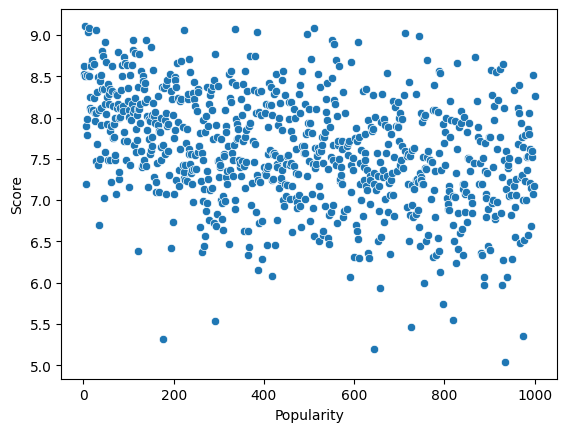

In [165]:
# Scatterplot of members v score

# Checks if is Isekai Theme
isIsekai = []
for subl in list(mal_data['Themes']):
    # print(subl)
    if type(subl) == float:
        isIsekai.append(False)
        continue
    state = True
    for them in subl:
        if them == "Isekai":
            isIsekai.append(True)
            state = False
            break
    if (state):
        isIsekai.append(False)
#

sns.scatterplot(data = mal_data, y = 'Score', x = 'Popularity')